In [2]:
import pandas as pd
import numpy as np
import qgrid
import scipy as sc
import time
import itertools    
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.matlib as matlib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from string import ascii_uppercase
from numpy import random

In [3]:
db = np.loadtxt('Frogs_MFCCs.data', delimiter = ',')
#Bufonidae - Rhinella - Rhinellagranulosa
#Dendrobatidae - Ameerega - Ameeregatrivittata
#Hylidae - 1.Dendropsophus, 2.Hypsiboas, 3.Osteocephalus, 4.Scinax - 1.HylaMinuta, 2.HypsiboasCinerascens, 2.HypsiboasCordobae, 3.OsteocephalusOophagus, 4.ScinaxRuber
#Leptodactylidae - 1.Adenomera, 2.Leptodactylus - 1.AdenomeraAndre, 1.AdenomeraHylaedactylus, 2.LeptodactylusFuscus

#Muestras
X = db[:, 0:22]

#Familias
Y = db[:, 22:25]

#Grupos
G = db[:, 25]

In [4]:
def classification_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):

        if y_e != y_r:
            err += 1

    return err/np.size(y_est)

## Naïve Bayes

The best model was GaussianNB(priors=None, var_smoothing=0.01) 

Sensibilidad: 0.8688518723793062 - Intervalo Sensibilidad: 0.11141417678173068 
Eficiencia: 0.9339911061700945 - Intervalo Eficiencia: 0.006169531095170382 
Precision: 0.8421474392066843 - Intervalo Precision: 0.1525188784499923 
F-Score: 0.8523433730771025 - Intervalo F-Score: 0.1276579542762799 
Error_Prueba: 0.0660088938299055 - Intervalo Error: 0.006169531095170405 
Tiempo ejecución: 1.1831090450286865


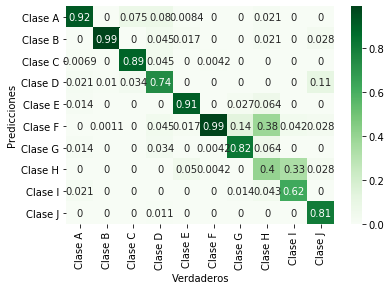

In [238]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import fbeta_score, make_scorer

def Naive_bayes_model(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])
    parameters = {'var_smoothing':(1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1)}
    NB = GaussianNB()
    clf = GridSearchCV(NB, parameters, cv=5)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y[:,2], test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore
        
        #code for calculating error
        error[j] = classification_error(Yest, Ytest)
          
    if graficar == True:
        j = 0
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')

    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelNB, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = Naive_bayes_model(graficar = True)
print('The best model was', modelNB,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)

,var_smoothing,sensitivity,IC_sensitivity
0,0.01,0.934102,0.934102
1,0.02,0.931380,0.931380
2,0.03,0.928482,0.928482
3,0.04,0.927578,0.927578
4,0.05,0.927216,0.927216
5,0.06,0.926127,0.926127
6,0.07,0.924676,0.924676
7,0.08,0.924132,0.924132
8,0.09,0.923226,0.923226
9,0.10,0.921228,0.921228


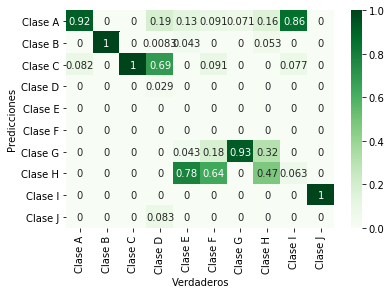

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer
from sklearn.model_selection import GroupShuffleSplit

def Naive_bayes_model(graficar = False):
    initial_time = time.time()
    group_ShuffleSplit = GroupShuffleSplit(n_splits=60, train_size=.75, random_state=42)
    scores = {'ROC': 'roc', 'Accuracy': make_scorer(accuracy_score), 'Recall': make_scorer(recall_score, average = "micro")}
    parameters = {'var_smoothing':(1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1)}
    NB = GaussianNB()
    clf = GridSearchCV(NB, parameters, return_train_score=True, scoring = scores, refit='Recall', cv=group_ShuffleSplit.get_n_splits(X, Y[:,2], G))
    scaler = MinMaxScaler() #Escala entre 0 y 1
    scaler.fit_transform(X)
    for train, test in group_ShuffleSplit.split(X, Y[:,2], G):
        Xtrain = X[train,:]
        Ytrain = Y[train,2]
        Xtest = X[test,:]
        Ytest = Y[test,2]
    clf.fit(Xtrain, Ytrain)
    Yest = clf.best_estimator_.predict(Xtest)
    if graficar == True:
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')
    return clf

clf = Naive_bayes_model(graficar = True)
# clf.cv_results_
# clf.best_score_
# results
pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_Recall"], columns=["sensitivity"]),pd.DataFrame(clf.cv_results_["mean_test_Accuracy"], columns=["IC_sensitivity"])],axis=1)

# pd.DataFrame(data = clf.cv_results_)
# df

## KNN

The best model was KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform') 

Sensibilidad: 0.9736070159799235 - Intervalo Sensibilidad: 0.0335767869647991 
Eficiencia: 0.9881878821567538 - Intervalo Eficiencia: 0.0026476596558167847 
Precision: 0.9683006406173007 - Intervalo Precision: 0.038977470173700776 
F-Score: 0.9705481401088963 - Intervalo F-Score: 0.031381166801988374 
Error_Prueba: 0.011812117843246248 - Intervalo Error: 0.0026476596558167942 
Tiempo ejecución: 67.05962538719177


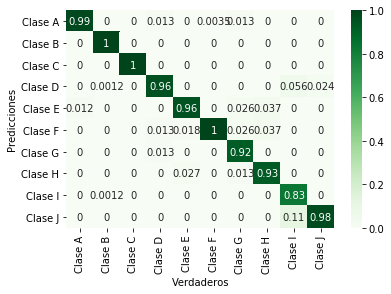

In [5]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_model(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])   
    parameters = {'n_neighbors':(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)}
    KNN = KNeighborsClassifier()
    clf = GridSearchCV(KNN, parameters)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y[:,2], test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating confusion matrix 
        _confusion_matrix_ = confusion_matrix(Ytest, Yest)
        TN_array[j] = _confusion_matrix_[0][0]
        FP_array[j] = _confusion_matrix_[0][1]
        FN_array[j] = _confusion_matrix_[1][0]
        TP_array[j] = _confusion_matrix_[1][1]
                
        error[j] = classification_error(Yest, Ytest)
          
    if graficar == True:
        j = 0
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')

    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelKNN, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = KNN_model(graficar = True)
print('The best model was', modelKNN,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)

## Redes Neuronales Artificiales

The best model was MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False) 

Sensibilidad: 0.9364934868886028 - Intervalo Sensibilidad: 0.05847320380157835 
Eficiencia: 0.9755419677598666 - Intervalo Eficiencia: 0.004924970857884738 
Precision: 0.9422661304167178 - Intervalo Precision: 0.0673808332039645 
F-Score: 0.9381629141262419 - Intervalo F-Score: 0.05531144307460179 
Error_Prueba: 0.024458032240133407 - Intervalo Error: 0.004924970857884755 
Tiempo ejecución: 981.588841676712


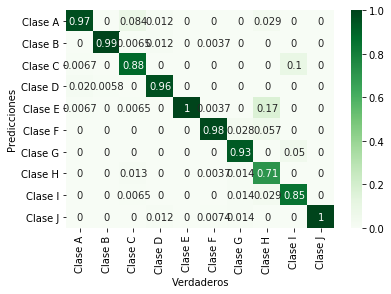

In [12]:
from sklearn.neural_network import MLPClassifier

def RNA_model(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])   
    parameters = {'hidden_layer_sizes':[x for x in itertools.product((5,10),repeat=2)]}
    RNA = MLPClassifier(activation='tanh',max_iter = 1000)
    clf = GridSearchCV(RNA, parameters)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y[:,2], test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore
        
        #code for calculating error
        error[j] = classification_error(Yest, Ytest)
          
    if graficar == True:
        j = 0
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')

    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelRNA, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = RNA_model(graficar = True)
print('The best model was', modelRNA,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)

## Random forest

The best model was RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

Sensibilidad: 0.9357938004699662 - Intervalo Sensibilidad: 0.0768885997409052 
Eficiencia: 0.9799888827126181 - Intervalo Eficiencia: 0.003666177309136463 
Precision: 0.9634933737555353 - Intervalo Precision: 0.04021418018938363 
F-Score: 0.9477790195887833 - Intervalo F-Score: 0.05063885166210139 
Error_Prueba: 0.020011117287381877 - Intervalo Error: 0.0036661773091364418 
Tiempo ejecución: 941.741144657135


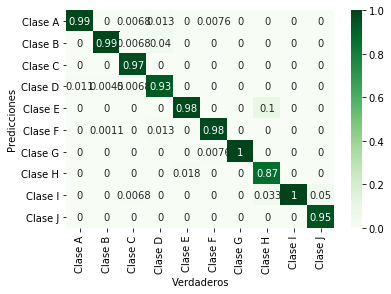

In [9]:
from sklearn.ensemble import RandomForestClassifier

def RF_model(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])
    parameters = {'n_estimators':(5, 10, 20, 50, 100),
                 'max_features':(2, 5, 10, 13, 15, 19, 22)}
    RF = RandomForestClassifier()
    clf = GridSearchCV(RF, parameters)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y[:,2], test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating confusion matrix 
        _confusion_matrix_ = confusion_matrix(Ytest, Yest)
        TN_array[j] = _confusion_matrix_[0][0]
        FP_array[j] = _confusion_matrix_[0][1]
        FN_array[j] = _confusion_matrix_[1][0]
        TP_array[j] = _confusion_matrix_[1][1]
                
        error[j] = classification_error(Yest, Ytest)
          
    if graficar == True:
        j = 0
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')

    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelRF, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = RF_model(graficar = True)
print('The best model was', modelRF,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)

## Maquinas de Soporte Vectorial con kernel lineal y con kernel RBF.

The best model was SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False) 

Sensibilidad: 0.9721231421421084 - Intervalo Sensibilidad: 0.04496304562733434 
Eficiencia: 0.9898554752640356 - Intervalo Eficiencia: 0.0028445649653222136 
Precision: 0.980971144065528 - Intervalo Precision: 0.024278824840633872 
F-Score: 0.9759901594184223 - Intervalo F-Score: 0.02995073017016384 
Error_Prueba: 0.010144524735964425 - Intervalo Error: 0.002844564965322224 
Tiempo ejecución: 2125.8703243732452


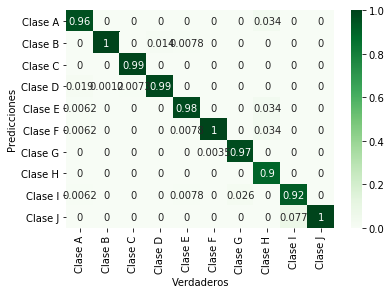

In [11]:
from sklearn.svm import SVC

def SVC_model(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])
    parameters = {'kernel':('linear', 'rbf'),
                 'C':(0.001, 0.01, 0.1, 1, 10, 100, 200, 300),
                 'gamma':(0.001, 0.01, 0.1, 1)}
    SupportVC = SVC(decision_function_shape='ovo' , probability = True)
    clf = GridSearchCV(SupportVC, parameters)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y[:,2], test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating confusion matrix 
        _confusion_matrix_ = confusion_matrix(Ytest, Yest)
        TN_array[j] = _confusion_matrix_[0][0]
        FP_array[j] = _confusion_matrix_[0][1]
        FN_array[j] = _confusion_matrix_[1][0]
        TP_array[j] = _confusion_matrix_[1][1]
                
        error[j] = classification_error(Yest, Ytest)
          
    if graficar == True:
        j = 0
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')

    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelSVC, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = SVC_model(graficar = True)
print('The best model was', modelSVC,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)